In [1]:
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
from helper_functions import linear_fit, non_linear_fit, RBF, MSE

## Function approximation

### Non-linear

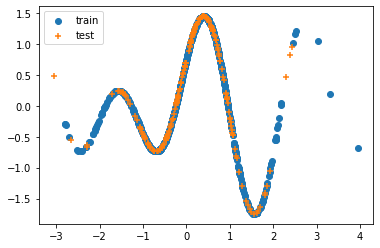

In [2]:
xB, fB = np.genfromtxt('data/nonlinear_function_data.txt').T
xB_train, xB_test, fB_train,  fB_test = train_test_split(xB, fB, test_size=0.2, random_state = 42, shuffle=False)
plt.scatter(xB_train,fB_train, label='train')
plt.scatter(xB_test,fB_test, marker='+', label='test')
plt.legend()

,params,mean_test_score,mean_score_time
42,"{'L': 100, 'eps': 1, 'rcond': None}",9.298891e+06,0.005395
30,"{'L': 50, 'eps': 1, 'rcond': None}",6.170797e+06,0.002997
39,"{'L': 100, 'eps': 0.5, 'rcond': None}",8.389726e+03,0.005195
18,"{'L': 20, 'eps': 1, 'rcond': None}",5.680229e+03,0.001000
27,"{'L': 50, 'eps': 0.5, 'rcond': None}",1.007468e+03,0.002397


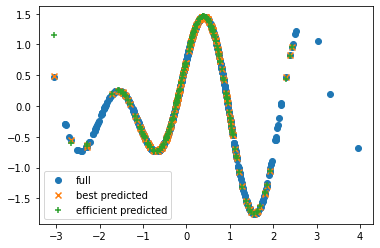

In [3]:
# Rigorous estimate based on score
params = {'eps':[0.1,0.5,1,5], 'L':[10, 20, 50, 100], 'rcond':[None, 0.005, 0.01]}
rbf = RBF(0, 0)
rbf_cv = GridSearchCV(rbf, params, scoring=lambda mod, _, __: 1./MSE(fB_test, mod.predict(xB_test)))
rbf_cv.fit(xB_train, fB_train)
display(pd.DataFrame(rbf_cv.cv_results_)[['params',
                                          'mean_test_score',
                                          'mean_score_time']].sort_values('mean_test_score',ascending=False).head())
fBhat = rbf_cv.best_estimator_.predict(xB_test)
plt.scatter(xB, fB, label='full')
plt.scatter(xB_test,fBhat, marker='x', label='best predicted')
# Hand-waving 'efficient' estimate
rbf_judgement = RBF(20, 1.)
rbf_judgement.fit(xB_train, fB_train)
fBhat3 = rbf_judgement.predict(xB_test)
plt.scatter(xB_test,fBhat3, marker='+', label='efficient predicted')
plt.legend()

## Vector field approximation

### Non-linear

In [4]:
x0 = np.genfromtxt('data/nonlinear_vectorfield_data_x0.txt')
x1 = np.genfromtxt('data/nonlinear_vectorfield_data_x1.txt')
x0_train, x0_test, x1_train, x1_test = train_test_split(x0, x1, test_size=0.2, random_state = 42, shuffle=False)
dt = 1.
v = (x1 - x0)/dt
v_train = (x1_train - x0_train)/dt
v_test = (x1_test - x0_test)/dt

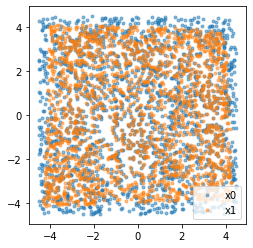

In [5]:
plt.scatter(x0[:,0], x0[:,1],marker='.', label='x0',alpha=0.5)
plt.scatter(x1[:,0], x1[:,1],marker='.', label='x1', alpha=0.5)
plt.gca().set_aspect('equal')
plt.legend()

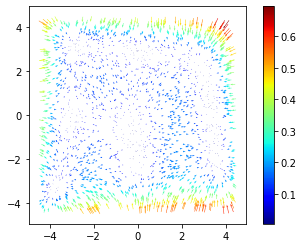

In [6]:
plt.quiver(x0[:,0], x0[:,1], v[:,0], v[:,1], np.linalg.norm(v,axis=1),cmap='jet')
plt.gca().set_aspect('equal')
plt.colorbar()

In [7]:
A = linear_fit(x0, v)

Got coefficients for the fit f_hat(x) = k*x + m, as 
k = -0.01, m = -0.0


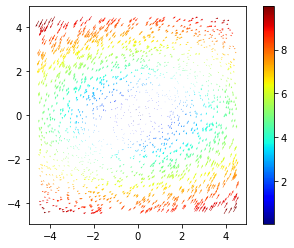

In [8]:
vhat = x0@A.T
plt.quiver(x0[:,0], x0[:,1], vhat[:,0], vhat[:,1], np.linalg.norm(vhat,axis=1),cmap='jet')
plt.gca().set_aspect('equal')
plt.colorbar()

In [10]:
# Rigorous estimate based on score
params = {'eps':[0.1,0.5,1,5], 'L':[10, 20, 50, 100, 500], 'rcond':[None, 0.005, 0.01]}
rbf0 = RBF(0, 0)
rbf_cv = GridSearchCV(rbf0, params, scoring=lambda mod, _, __: 1./MSE(x0_test, mod.predict(v_test)))
rbf_cv.fit(x0_train, v_train)
display(pd.DataFrame(rbf_cv.cv_results_)[['params',
                                          'mean_test_score',
                                          'mean_score_time']].sort_values('mean_test_score',ascending=False).head())

,params,mean_test_score,mean_score_time
11,"{'L': 10, 'eps': 5, 'rcond': 0.01}",0.075324,0.000999
50,"{'L': 500, 'eps': 0.1, 'rcond': 0.01}",0.075286,0.046357
23,"{'L': 20, 'eps': 5, 'rcond': 0.01}",0.075277,0.001599
25,"{'L': 50, 'eps': 0.1, 'rcond': 0.005}",0.075247,0.003996
37,"{'L': 100, 'eps': 0.1, 'rcond': 0.005}",0.075243,0.011589


0.0005286403734872176

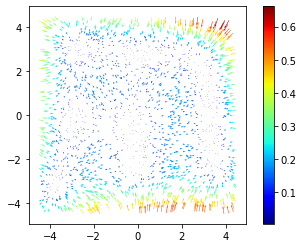

In [11]:
# Judgement based
rbf = RBF(20, 5)
rbf.fit(x0_train, v_train)
vhat = rbf.predict(x0)
plt.quiver(x0[:,0], x0[:,1], vhat[:,0], vhat[:,1], np.linalg.norm(vhat,axis=1),cmap='jet')
plt.gca().set_aspect('equal')
plt.colorbar()
MSE(v, vhat)

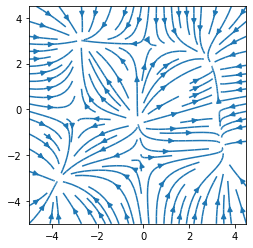

In [12]:
X, Y = np.meshgrid(np.arange(-5,5, .5), np.arange(-5,5,.5))
XY = np.array([X.flatten(), Y.flatten()]).T
UV = rbf.predict(XY)
U, V = [W.reshape(X.shape) for W in UV.T]
plt.streamplot(X, Y, U, V)
plt.gca().set_aspect('equal')

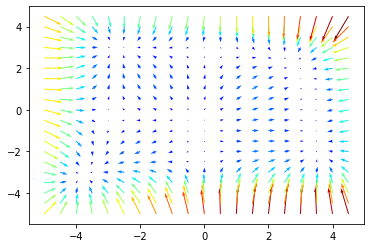

In [13]:
plt.quiver(X, Y, U, V, np.linalg.norm(UV,axis=1),cmap='jet')

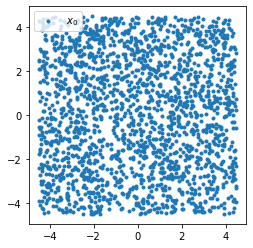

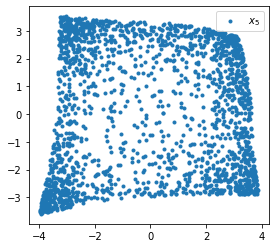

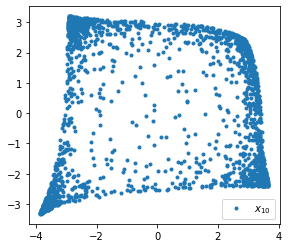

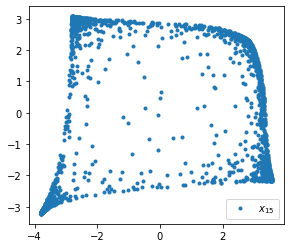

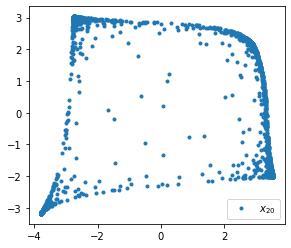

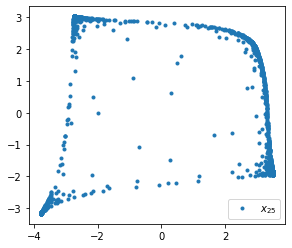

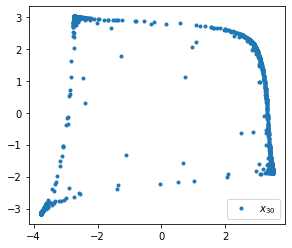

In [14]:
x = x0.copy()
plt.scatter(x[:,0], x[:,1], marker='.', label=r'$x_0$')
plt.gca().set_aspect('equal')
plt.legend()
for i in range(1,31):
    vhat = rbf.predict(x)
    x += vhat*dt
    if(not i%5):
        plt.figure()
        plt.scatter(x[:,0], x[:,1], marker='.', label=rf'$x_{{{i}}}$')
        plt.gca().set_aspect('equal')
        plt.legend()